In [2]:
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef
import pandas as pd
import random
import re

sns.set(font_scale=1.5)

In [4]:
df = pd.read_csv("pira.csv", sep = ';')
df_OO = df[['abstract', 'question_en_origin', 'answer_en_origin', 'question_meaningful']]
df_OO.columns = ['abstract', 'question', 'answer', 'question_meaningful']
df_OP = df[['abstract', 'question_en_origin', 'answer_en_validate', 'question_meaningful']]
df_OP.columns = ['abstract', 'question', 'answer', 'question_meaningful']
df_PO = df[['abstract', 'question_en_paraphase', 'answer_en_origin', 'question_meaningful']]
df_PO.columns = ['abstract', 'question', 'answer', 'question_meaningful']
df_PP = df[['abstract', 'question_en_paraphase', 'answer_en_validate', 'question_meaningful']]
df_PP.columns = ['abstract', 'question', 'answer', 'question_meaningful']
df = pd.concat([df_OO, df_OP, df_PO, df_PP])
df = df.reset_index(drop=True)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'pira.csv'

In [ ]:
print(df.shape)

(9084, 4)


In [ ]:
df.dropna(subset=['question', 'answer', 'question_meaningful'], inplace=True)
df.shape

(8384, 4)

In [ ]:
# apenas questões cuja resposta não é um pedaço do texto
df['contain'] = df.apply(lambda x: x['answer'] in x['abstract'], axis=1)
df = df[df['contain'] == False]
print(len(df))

6914


In [ ]:
#df = df[(df['question_meaningful'] == 1) | (df['question_meaningful'] == 5)]

df['labels'] = [1 if x > 3 else 0 for x in df['question_meaningful']] # Só tem respostas questões avaliadas com mais que 2

df['abstract'] = df['abstract'].apply(lambda x: re.sub('<[^<]+?>', '', x))
df['abstract'] = df['abstract'].apply(lambda x: re.sub(r'\n', '', x))
df['abstract'] = df['abstract'].apply(lambda x: re.sub(r'\t', '', x))
df['question'] = df['question'].apply(lambda x: re.sub(r'\n', '', x))
df['answer'] = df['answer'].apply(lambda x: re.sub(r'\n', '', x))
df['text'] = df['abstract'] + " </s> " + df['question']
df.head()

,abstract,question,answer,question_meaningful,contain,labels,text
2,The Cretaceous Bauru Group of the Paraná Basin...,When was the Bed of Ibaté formed?,Late Cretaceous.,5.0,False,1,The Cretaceous Bauru Group of the Paraná Basin...
3,This study presents new stable carbon and oxyg...,From where are the lacustrine carbonate rock s...,From a well drilled in the Santos Basin.,4.0,False,1,This study presents new stable carbon and oxyg...
5,The objective of this work is to describe the ...,Which season the 10-m wind over the ESGA blows...,Autumn season.,5.0,False,1,The objective of this work is to describe the ...
6,"Invented by Petrobras in 1996, the torpedo anc...",Who invented the torpedo anchor?,Petrobras.,5.0,False,1,"Invented by Petrobras in 1996, the torpedo anc..."
7,The population structure of Mithraculus forcep...,Which other kind of species resides close to t...,Other decapod crustaceans.,5.0,False,1,The population structure of Mithraculus forcep...


In [ ]:
# Balancear o dataset. Mesmo número de questões com valor == 5 que de valor == 1 (242)
df_meaningful = df[(df['labels'] == 1)]

df_non_meaningful = df[(df['labels'] == 0)]

df_mean_reduced = df_meaningful.sample(n = len(df_non_meaningful), random_state = 3)

df = pd.concat([df_non_meaningful, df_mean_reduced])
df.shape

(2466, 7)

In [ ]:
print('Questions with answers: ' + str(len(df[df['labels'] == 1])))
print('Questions without answers: ' + str(len(df[df['labels'] == 0])))

Questions with answers: 1233
Questions without answers: 1233


In [ ]:
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(df, test_size=0.15, random_state=1002)

In [ ]:
print("Simple assignment to the largest class: " + str(len(eval_df[eval_df['labels'] == 1])/len(eval_df)))

Simple assignment to the largest class: 0.5


In [ ]:
# Build the model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())# Train the model using the training data
model.fit(train_df['text'].values, train_df['labels'].values)# Predict the categories of the test data

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [ ]:
predicted_categories = model.predict(eval_df['text'].values)

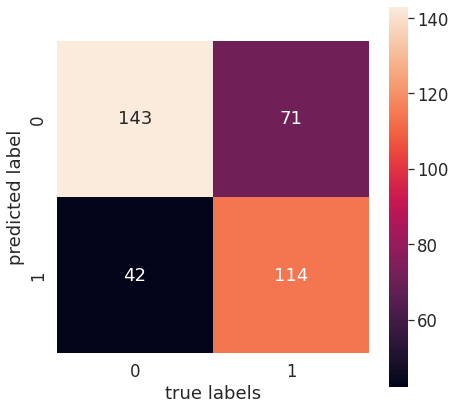

The accuracy is 0.6945945945945946
The matthews_corrcoef is 0.39406086886175407
The f1_score is 0.6927068404148201


In [ ]:
# plot the confusion matrix
mat = confusion_matrix(eval_df['labels'].values, predicted_categories)

plt.figure(figsize=(7, 7))
sns.heatmap(mat.T, square=True, annot=True, fmt="d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

print("The accuracy is {}".format(accuracy_score(eval_df['labels'].values, predicted_categories)))
print("The matthews_corrcoef is {}".format(matthews_corrcoef(eval_df['labels'].values, predicted_categories)))
print("The f1_score is {}".format(f1_score(eval_df['labels'].values, predicted_categories, average='weighted')))

In [ ]:
!pip install transformers

In [ ]:
!pip install simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=2, overwrite_output_dir = True)

# Create a ClassificationModel
model = ClassificationModel(
    "roberta", "roberta-base", args=model_args, use_cuda = False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [ ]:
# Train the model
model.train_model(train_df)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2


In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

In [ ]:
accuracy_transformer = 860/(860+178)
print('Accuracy: ' + str(accuracy_transformer))

Accuracy: 0.8285163776493256


In [ ]:
number = 300

predictions, raw_outputs = model.predict([df['text'].iloc[number]])
print('Prediction: ' + str(predictions))
print('Label: ' + str(df['labels'].iloc[number]))
print('Question and text: ' + str([df['text'].iloc[number]]))
print('Answer: ' + str([df['answer'].iloc[number]]))

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



Prediction: [1]
Label: 0
Question and text: ["The Petroleo Brasileiro SA (Petrobras), a state-owned oil company utilizes its floating production storage and offloading (FPSO) P-50 vessel to 16 production wells at the Albacora Laste field in Campos basin. FPSO symbolizes Brazil's plans to reach oil self-sufficiency by mid-2006. The FPSO will process oil pumped from the field 150 km off Rio de Janeiro and each peak production of 180,000 b/d by August, which represents around 10% of Brazil's crude oil output. The P-50 will also be able to handle 6M cu m/day of natural gas. The P-50 and P-34, also an FPSO, are to begin processing 20,000 b/d of oil at Jubarte field. They will raise national production to 1.9M b/d in 2006, surpassing domestic needs and making Brazil reach oil self-sufficiency. </s> What is the estimated oil processing capacity of the P-50 ship?"]
Answer: ['180,000 b/d and 6M cu m/day of natural gas']


In [ ]:
predictions, raw_outputs = model.predict(["Sam was a Wizard"])

In [ ]:
### answering
from transformers import BartTokenizer, BartForQuestionAnswering
import torch

tokenizer = BartTokenizer.from_pretrained('valhalla/bart-large-finetuned-squadv1')
# outra possibilidade 'valhalla/longformer-base-4096-finetuned-squadv1'
model = BartForQuestionAnswering.from_pretrained('valhalla/bart-large-finetuned-squadv1')

In [ ]:
test_labels = []
test_outputs = []

for i in range(len(eval_df)):
  question = df.loc[df.index[i], 'question']
  text = df.loc[df.index[i], 'abstract']
  encoding = tokenizer(question, text, return_tensors='pt')
  input_ids = encoding['input_ids']
  attention_mask = encoding['attention_mask']
  
  start_scores, end_scores = model(input_ids, attention_mask=attention_mask, output_attentions=False)[:2]
  
  all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
  answer = ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1])
  answer = tokenizer.convert_tokens_to_ids(answer.split())
  answer = tokenizer.decode(answer)
  test_labels.append(df.loc[df.index[i], 'answer'])
  test_outputs.append(answer)

In [ ]:
!pip install rouge_score

from rouge_score import rouge_scorer
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import SmoothingFunction
from nltk.metrics import f_measure
import nltk
nltk.download('punkt')
import string
import re
import collections

def get_tokens(sentence):
    tokens = word_tokenize(sentence)
    return tokens

def normalize_text(sentence):

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_punc(lower(sentence)))

def f1_score_qa(text_true,text_pred):
    "squad"
    text_true = normalize_text(text_true)
    text_pred = normalize_text(text_pred)
    true_tokens = get_tokens(text_true)
    pred_tokens = get_tokens(text_pred)
    common = collections.Counter(true_tokens) & collections.Counter(pred_tokens)
    num_same = sum(common.values())
    if len(true_tokens) == 0 or len(pred_tokens) == 0:
        return int(true_tokens==pred_tokens),int(true_tokens==pred_tokens),int(true_tokens==pred_tokens)
    if num_same == 0:
        return 0,0,0
    precision = 1 * num_same / len(pred_tokens)
    recall = 1 * num_same / len(true_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, precision, recall

def em_qa(text_true,text_pred):
    return int(normalize_text(text_true) == normalize_text(text_pred))

def rouge_l_qa(text_true,text_pred):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(text_true,text_pred)

    return scores["rougeL"].fmeasure

def em_qa_overall(text_true,text_pred):
    scores = 0
    for i in range(len(text_true)):
        scores += em_qa(text_true[i],text_pred[i])
    score = scores/len(text_true)
    return score

def f1_score_qa_overall(text_true,text_pred):
    f = 0
    for i in range(len(text_true)):
        fi,pi,ri = f1_score_qa(text_true[i],text_pred[i])
        f+=fi
    f = f/len(text_true)
    return f

def rouge_l_qa_overall(text_true,text_pred):
    scores = 0
    for i in range(len(text_true)):
        score = rouge_l_qa(text_true[i],text_pred[i])
        scores += score
    scores = scores/len(text_true)
    return scores

def scores(func,text_true,text_pred):
    if func=='rouge_l_qa':
        score_value = rouge_l_qa(text_true,text_pred)
    if func=='em_qa':
        score_value = em_qa(text_true,text_pred)
    if func=='f1_score_qa':
        score_value = f1_score_qa(text_true,text_pred)
    return (func, score_value)
        

def overall(func,text_true,text_pred):
    if func=='rouge_l_qa_overall':
        score_value = rouge_l_qa_overall(text_true,text_pred)
    if func=='em_qa_overall':
        score_value = em_qa_overall(text_true,text_pred)
    if func=='f1_score_qa_overall':
        score_value = f1_score_qa_overall(text_true,text_pred)
    return (func, score_value)

In [ ]:
print("f1-score: " + str(overall("f1_score_qa_overall", test_labels, test_outputs)))
print("EM: " + str(overall('em_qa_overall', test_labels, test_outputs)))
print("Rouge-L: " + str(overall('rouge_l_qa_overall', test_labels, test_outputs)))